In [2]:
%matplotlib inline
import pandas as pd
import sqlite3 as sq3
import matplotlib.pyplot as plt

In [3]:
db_loc="./data/sql/chinook.db"
def run_query(q):
    with sq3.connect(db_loc) as conn:
        return pd.read_sql(q,conn)
    
def run_command(q):
    with sq3.connect(db_loc) as conn:
        conn.isolation_level=None
        return conn.execute(q)
def show_tables():
    q='SELECT name,type FROM sqlite_master WHERE type IN ("table","view")'
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
query="""
with total_USA as (
  select il.quantity total_usa from invoice_line il
inner JOIN invoice i ON il.invoice_id = i.invoice_id
LEFT JOIN track t ON il.track_id = t.track_id
LEFT JOIN genre g ON t.genre_id = g.genre_id
where i.billing_country='USA'
)
select g.name, sum(il.quantity) tracks_sold, (cast(sum(il.quantity) as float)/cast((SELECT sum(total_usa) from total_USA) as float))percentage_sold from invoice_line il
inner JOIN invoice i ON il.invoice_id = i.invoice_id
LEFT JOIN track t ON il.track_id = t.track_id
LEFT JOIN genre g ON t.genre_id = g.genre_id
where i.billing_country='USA'
GROUP BY g.genre_id
order by tracks_sold desc"""
albums_to_buy=run_query(query)
query_1="""
with total_price_USA as (
  select (il.quantity*il.unit_price) total_price_usa from invoice_line il
inner JOIN invoice i ON il.invoice_id = i.invoice_id
LEFT JOIN track t ON il.track_id = t.track_id
LEFT JOIN genre g ON t.genre_id = g.genre_id
where i.billing_country='USA'
)
select g.name, sum((il.quantity* il.unit_price)) tracks_price_sold, (cast(sum(il.quantity* il.unit_price) as float)/cast((SELECT sum(total_price_usa) from total_price_USA) as float))percentage_sold from invoice_line il
inner JOIN invoice i ON il.invoice_id = i.invoice_id
LEFT JOIN track t ON il.track_id = t.track_id
LEFT JOIN genre g ON t.genre_id = g.genre_id
where i.billing_country='USA'
GROUP BY g.genre_id
order by tracks_price_sold desc"""
albums_by_price=run_query(query_1)

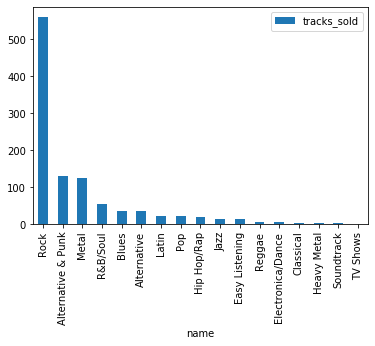

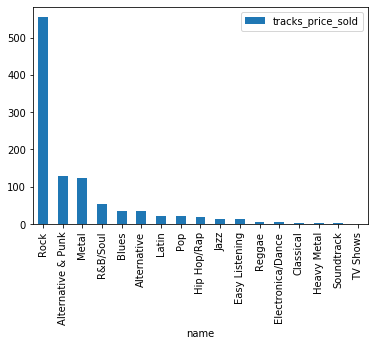

In [5]:
albums_to_buy.plot.bar(x="name",y="tracks_sold")
albums_by_price.plot.bar(x="name",y="tracks_price_sold")

Seems like by quantity Rock sells more in the USA and this matches the comparison by aggregation pf price and quantity as  all records have a record of only one quantiy hence popularity and revenue match.
Should purchase:
Punk, Blues and Pop album

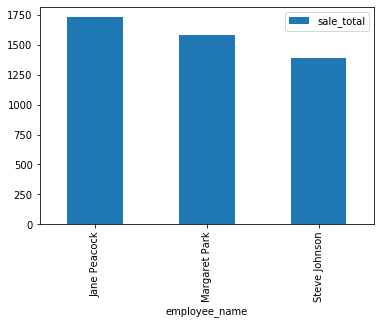

In [6]:
query_2="""
SELECT total(total) sale_total, (e.first_name||' '||e.last_name)employee_name,e.hire_date from invoice i
INNER JOIN customer c ON i.customer_id = c.customer_id
LEFT JOIN employee e ON c.support_rep_id = e.employee_id
GROUP BY employee_id
ORDER BY 1 desc;
"""
employee_sale_total=run_query(query_2)
employee_sale_total.plot.bar(x="employee_name",y="sale_total")

Jane Peacock has the most sales, but she has also been with the company longer as compared to the other 2 sales reps but the difference is only a few months which can be attributed to her lead

In [7]:
query_3="""
SELECT
  CASE
    WHEN (
      SELECT count(*) FROM customer WHERE country=c.country
    )=1 then 'Other'
    ELSE
      c.country
    END cntry,
  count(DISTINCT(c.customer_id)) total_customers,
  sum(total) total_sales,
  (sum(total) /count(DISTINCT(c.customer_id))) avg_sales_per_cust,
  (sum(total)/count(DISTINCT(i.invoice_id)))  avg_order_value
FROM customer c
INNER JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY cntry
ORDER BY 2 DESC
"""
sales_by_country=run_query(query_3)
sales_by_country

,cntry,total_customers,total_sales,avg_sales_per_cust,avg_order_value
0,Other,15,1094.94,72.996000,7.448571
1,USA,13,1040.49,80.037692,7.942672
2,Canada,8,535.59,66.948750,7.047237
3,Brazil,5,427.68,85.536000,7.011148
4,France,5,389.07,77.814000,7.781400
5,Germany,4,334.62,83.655000,8.161463
6,United Kingdom,3,245.52,81.840000,8.768571
7,Czech Republic,2,273.24,136.620000,9.108000
8,India,2,183.15,91.575000,8.721429
9,Portugal,2,185.13,92.565000,6.383793


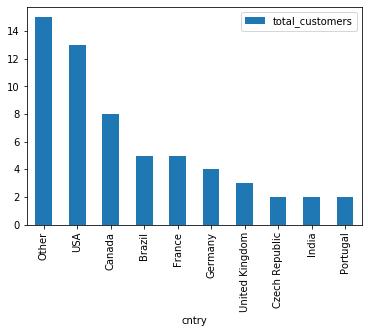

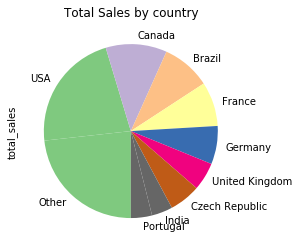

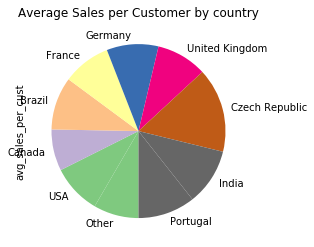

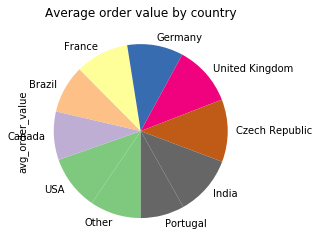

In [8]:
sales_by_country.plot.bar(x="cntry",y="total_customers")
sales_by_country.plot(kind='pie',y="total_sales",title="Total Sales by country",legend=False, labels=sales_by_country["cntry"],colormap=plt.cm.Accent,startangle=-90,wedgeprops={'linewidth':0},counterclock=False)
sales_by_country.plot(kind='pie',y="avg_sales_per_cust",title="Average Sales per Customer by country",legend=False, labels=sales_by_country["cntry"],colormap=plt.cm.Accent,startangle=-90,wedgeprops={'linewidth':0},counterclock=False)
sales_by_country.plot(kind='pie',y="avg_order_value",title="Average order value by country",legend=False, labels=sales_by_country["cntry"],colormap=plt.cm.Accent,startangle=-90,wedgeprops={'linewidth':0},counterclock=False)


In terms of sheer quantities,As a single block the USA has the most in customers and total sales they fall behind the Czech republic who on average customers have a spend more per sale and have a higher basket size.
To benefit most from this, they need to market more to the Czech republic and the United Kingdom. In spite of the few customers, the customers spend more on each sale than the Average customer in the United States

In [9]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
